In [1]:
# https://www.biblesupersearch.com/bible-downloads/
# ^ La Bible de l'Épée

# CREDIT(s): https://www.kaggle.com/code/jjmewtw/total-bible-text-study-eda-cluster-bert-nlp

In [2]:
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [3]:
# conda install numpy pandas nltk matplotlib seaborn wordcloud scikit-learn tensorflow tensorflow-hub openpyxl
# !pip install tokenization
# !pip install kaggle

In [4]:
# !cat ~/.kaggle/kaggle.json

In [ ]:
import numpy as np
import pandas as pd
import nltk

# nltk.download('stopwords')
# nltk.download('punkt)
# nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from collections import Counter, defaultdict
import tokenization
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

import operator

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

import gc

In [6]:
df = pd.read_excel("French_Bible.xlsx", header=5)

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text
0,1,Genèse,1,1,1,"¶ Dieu, au commencement, créa les cieux et la ..."
1,2,Genèse,1,1,2,"en une masse fluide et sans forme, et les ténè..."
2,3,Genèse,1,1,3,¶ Et Dieu dit: Que la lumière soit; et son ray...
3,4,Genèse,1,1,4,Et Dieu vit que la lumière était gracieuse; et...
4,5,Genèse,1,1,5,Et Dieu invita la lumière gracieuse; mais il c...
...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,L'Esprit et l'Épouse disent: Viens. Que celui ...
31098,31099,Apocalypse,66,22,18,Je proteste à quiconque entend les paroles de ...
31099,31100,Apocalypse,66,22,19,Et si quelqu'un retranche des paroles du livre...
31100,31101,Apocalypse,66,22,20,"¶ Celui qui rend témoignage de ces choses, dit..."


In [8]:
df_aux = pd.read_excel("French_Bible_Information.xlsx")

df_aux

,Book,Tanakh,King James Version,New Jerusalem Version,Time,Period,Location
0,Acts,NaN,44.0,51,80,Christian,Rome
1,Amos,17.0,30.0,37,-745,Monarchic,Israel
2,Baruch,NaN,NaN,32,-180,Hellenistic,Israel
3,1 Chronicles,38.0,13.0,13,-350,Persian,Israel
4,2 Chronicles,39.0,14.0,14,-350,Persian,Israel
...,...,...,...,...,...,...,...
68,Titus,NaN,56.0,63,100,Christian,Nicopolis
69,Tobit,NaN,NaN,17,-200,Hellenistic,Israel
70,Wisdom,NaN,NaN,27,-50,Maccabean,Israel
71,Zechariah,25.0,38.0,45,-500,Persian,Israel


In [9]:
sw = stopwords.words("french")

sw[:5]

['au', 'aux', 'avec', 'ce', 'ces']

In [10]:
matthieu = df[df["Book Name"] == "Matthieu"].iloc[0]

matthieu

Verse ID                                                   23146
Book Name                                               Matthieu
Book Number                                                   40
Chapter                                                        1
Verse                                                          1
Text           ¶ Livre généalogique de JÉSUS-CHRIST, fils de ...
Name: 23145, dtype: object

In [11]:
df["Testament"] = ""

df.loc[df.index < 23145, "Testament"] = "Ancien"
df.loc[df.index >= 23145, "Testament"] = "Nouveau"

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text,Testament
0,1,Genèse,1,1,1,"¶ Dieu, au commencement, créa les cieux et la ...",Ancien
1,2,Genèse,1,1,2,"en une masse fluide et sans forme, et les ténè...",Ancien
2,3,Genèse,1,1,3,¶ Et Dieu dit: Que la lumière soit; et son ray...,Ancien
3,4,Genèse,1,1,4,Et Dieu vit que la lumière était gracieuse; et...,Ancien
4,5,Genèse,1,1,5,Et Dieu invita la lumière gracieuse; mais il c...,Ancien
...,...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,L'Esprit et l'Épouse disent: Viens. Que celui ...,Nouveau
31098,31099,Apocalypse,66,22,18,Je proteste à quiconque entend les paroles de ...,Nouveau
31099,31100,Apocalypse,66,22,19,Et si quelqu'un retranche des paroles du livre...,Nouveau
31100,31101,Apocalypse,66,22,20,"¶ Celui qui rend témoignage de ces choses, dit...",Nouveau


In [12]:
df_enriched = df_aux.drop(["Tanakh", "New Jerusalem Version"], axis=1)
df_enriched["King James Version"] = df_enriched["King James Version"].replace(np.nan, 0)
df_enriched["King James Version"] = df_enriched["King James Version"].astype("int")
df_enriched = df_enriched.rename(columns={"Book": "Book_Name"})

df_enriched

,Book_Name,King James Version,Time,Period,Location
0,Acts,44,80,Christian,Rome
1,Amos,30,-745,Monarchic,Israel
2,Baruch,0,-180,Hellenistic,Israel
3,1 Chronicles,13,-350,Persian,Israel
4,2 Chronicles,14,-350,Persian,Israel
...,...,...,...,...,...
68,Titus,56,100,Christian,Nicopolis
69,Tobit,0,-200,Hellenistic,Israel
70,Wisdom,0,-50,Maccabean,Israel
71,Zechariah,38,-500,Persian,Israel


In [13]:
df = df.merge(df_enriched, left_on="Book Number", right_on="King James Version")

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text,Testament,Book_Name,King James Version,Time,Period,Location
0,1,Genèse,1,1,1,"¶ Dieu, au commencement, créa les cieux et la ...",Ancien,Genesis,1,-500,Persian,Israel
1,2,Genèse,1,1,2,"en une masse fluide et sans forme, et les ténè...",Ancien,Genesis,1,-500,Persian,Israel
2,3,Genèse,1,1,3,¶ Et Dieu dit: Que la lumière soit; et son ray...,Ancien,Genesis,1,-500,Persian,Israel
3,4,Genèse,1,1,4,Et Dieu vit que la lumière était gracieuse; et...,Ancien,Genesis,1,-500,Persian,Israel
4,5,Genèse,1,1,5,Et Dieu invita la lumière gracieuse; mais il c...,Ancien,Genesis,1,-500,Persian,Israel
...,...,...,...,...,...,...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,L'Esprit et l'Épouse disent: Viens. Que celui ...,Nouveau,Revelation,66,95,Christian,Patmos
31098,31099,Apocalypse,66,22,18,Je proteste à quiconque entend les paroles de ...,Nouveau,Revelation,66,95,Christian,Patmos
31099,31100,Apocalypse,66,22,19,Et si quelqu'un retranche des paroles du livre...,Nouveau,Revelation,66,95,Christian,Patmos
31100,31101,Apocalypse,66,22,20,"¶ Celui qui rend témoignage de ces choses, dit...",Nouveau,Revelation,66,95,Christian,Patmos


In [14]:
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
import string


def lower_column_t(series):
    return series.str.lower()


# def clean_interpunction(series):
#    return series.str.replace('[{}]'.format(string.punctuation), '')


def clean_interpunction(text):
    # Remove punctuation marks
    punctuation_marks = [".", ";", ":", ",", "'", '"', "¶", "!", "?"]
    for mark in punctuation_marks:
        text = text.replace(mark, "")

    # Remove line breaks
    text = text.replace("\n", "")
    text = text.replace("\r", "")

    return text


def lem(a):
    lemmatizer = WordNetLemmatizer()
    b = []
    for line in a:
        tokens = word_tokenize(line)
        lem_tokens = [
            lemmatizer.lemmatize(token) for token in tokens if token not in sw
        ]
        b.append(" ".join(lem_tokens))
    return b


def stem(a):
    stemmer = FrenchStemmer()
    return [stemmer.stem(word) for word in a]


def tokenize(a):
    return [word_tokenize(line, language="french") for line in a]


def flatten(a):
    return [" ".join(line) for line in a]


def count_words(a):
    return sum(
        [sum(1 for i in line if i.strip(string.punctuation).isalpha()) for line in a]
    )


def generate_ngrams(text, n_gram=1):
    tokens = [token for token in text.lower().split(" ") if token != ""]
    return [" ".join(tokens[i : i + n_gram]) for i in range(len(tokens) - n_gram + 1)]

In [15]:
df["Text"] = lower_column_t(df["Text"])
df["Text"] = df["Text"].apply(clean_interpunction)
df["Text_Lem"] = lem(df["Text"])
df["Text_Stem"] = stem(df["Text"])
df["Text_Stem_Lem"] = lem(df["Text_Stem"])
df["No Words"] = df["Text"].str.split().str.len()
# df = df.set_index('id')

df

,Verse ID,Book Name,Book Number,Chapter,Verse,Text,Testament,Book_Name,King James Version,Time,Period,Location,Text_Lem,Text_Stem,Text_Stem_Lem,No Words
0,1,Genèse,1,1,1,dieu au commencement créa les cieux et la terre,Ancien,Genesis,1,-500,Persian,Israel,dieu commencement créa cieux terre,dieu au commencement créa les cieux et la terr,dieu commencement créa cieux terr,9
1,2,Genèse,1,1,2,en une masse fluide et sans forme et les ténèb...,Ancien,Genesis,1,-500,Persian,Israel,masse fluide sans forme ténèbres surface lespa...,en une masse fluide et sans forme et les ténèb...,masse fluide sans forme ténèbres surface lespa...,25
2,3,Genèse,1,1,3,et dieu dit que la lumière soit et son rayonn...,Ancien,Genesis,1,-500,Persian,Israel,dieu dit lumière rayonnement,et dieu dit que la lumière soit et son rayonn...,dieu dit lumière rayonnement,11
3,4,Genèse,1,1,4,et dieu vit que la lumière était gracieuse et ...,Ancien,Genesis,1,-500,Persian,Israel,dieu vit lumière gracieuse dieu démêla lumière...,et dieu vit que la lumière était gracieuse et ...,dieu vit lumière gracieuse dieu démêla lumière...,16
4,5,Genèse,1,1,5,et dieu invita la lumière gracieuse mais il co...,Ancien,Genesis,1,-500,Persian,Israel,dieu invita lumière gracieuse convoqua ténèbre...,et dieu invita la lumière gracieuse mais il co...,dieu invita lumière gracieuse convoqua ténèbre...,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31097,31098,Apocalypse,66,22,17,lesprit et lépouse disent viens que celui qui ...,Nouveau,Revelation,66,95,Christian,Patmos,lesprit lépouse disent viens celui lentend dis...,lesprit et lépouse disent viens que celui qui ...,lesprit lépouse disent viens celui lentend dis...,29
31098,31099,Apocalypse,66,22,18,je proteste à quiconque entend les paroles de ...,Nouveau,Revelation,66,95,Christian,Patmos,proteste quiconque entend parole prophétie liv...,je proteste à quiconque entend les paroles de ...,proteste quiconque entend parole prophétie liv...,29
31099,31100,Apocalypse,66,22,19,et si quelquun retranche des paroles du livre ...,Nouveau,Revelation,66,95,Christian,Patmos,si quelquun retranche parole livre cette proph...,et si quelquun retranche des paroles du livre ...,si quelquun retranche parole livre cette proph...,33
31100,31101,Apocalypse,66,22,20,celui qui rend témoignage de ces choses dit o...,Nouveau,Revelation,66,95,Christian,Patmos,celui rend témoignage choses dit oui viens bie...,celui qui rend témoignage de ces choses dit o...,celui rend témoignage choses dit oui viens bie...,17


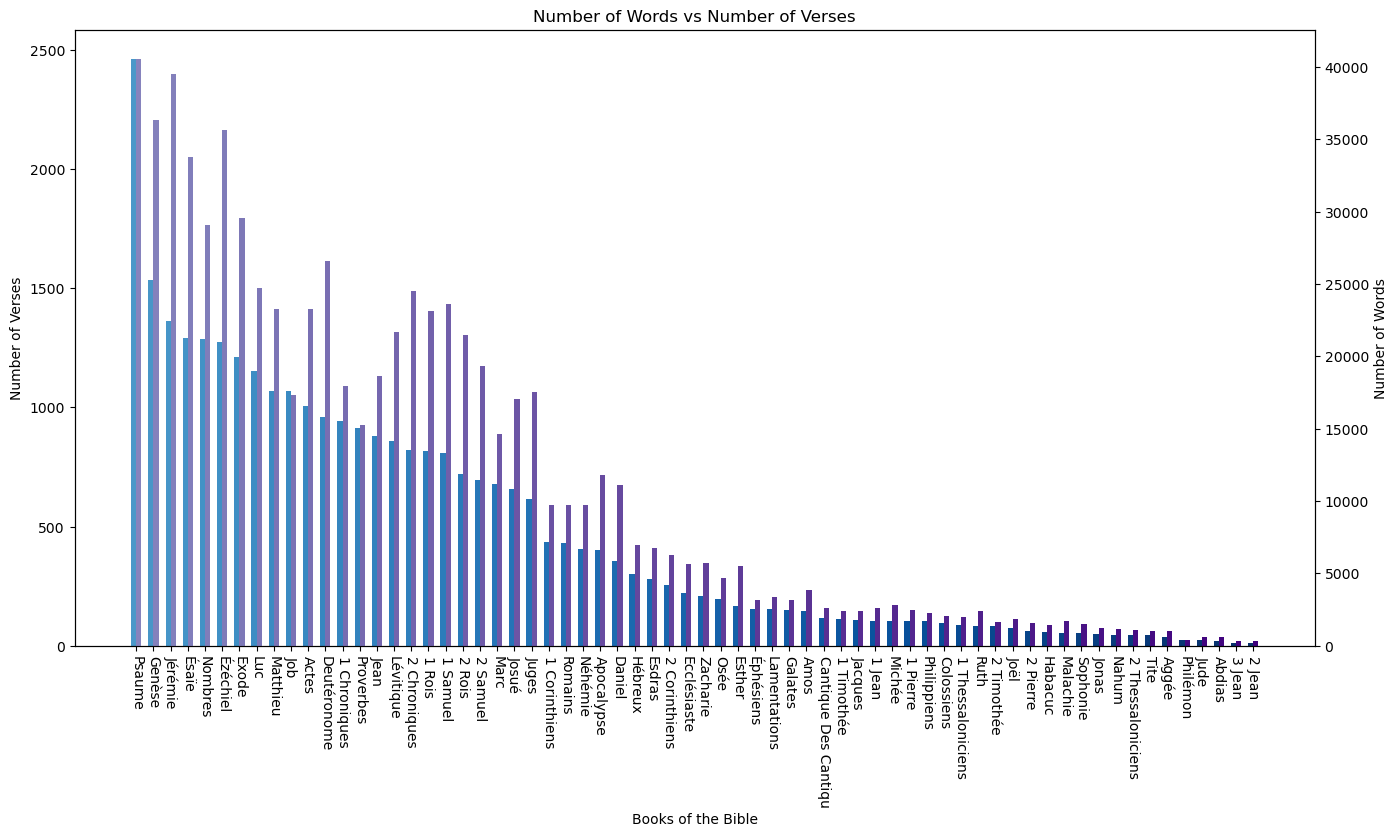

In [16]:
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

verse_words = (
    df.groupby("Book Name")
    .agg({"Book Number": "count", "No Words": "sum"})
    .sort_values(by="Book Number", ascending=False)
)
data1 = verse_words["Book Number"]
data2 = verse_words["No Words"]

plt.figure(figsize=(16, 8))
x = np.arange(66)
ax1 = plt.subplot(1, 1, 1)
w = 0.3

color = color_1
plt.title("Number of Words vs Number of Verses")
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel("Books of the Bible")
ax1.set_ylabel("Number of Verses")
ax1.bar(x, data1.values, color=color_1, width=w, align="center")

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel("Number of Words")
ax2.bar(x + w, data2, color=color_2, width=w, align="center")

plt.show()

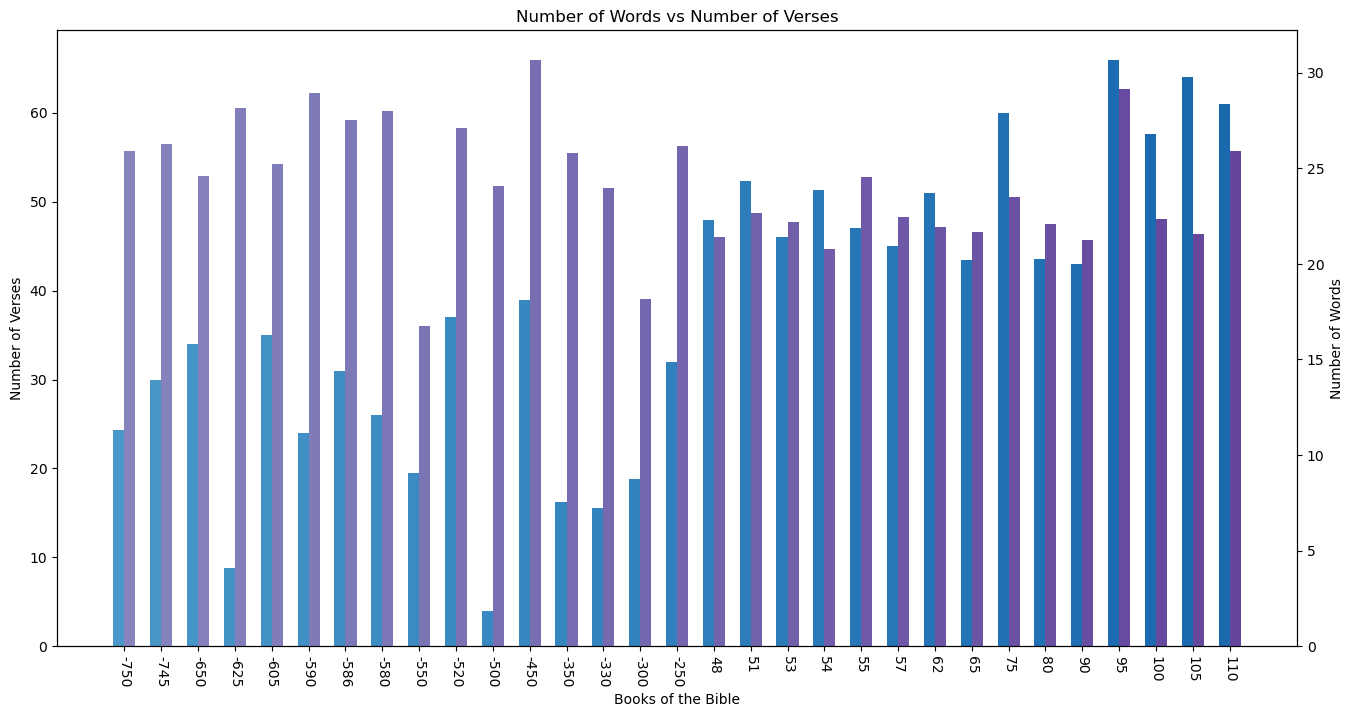

In [17]:
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

verse_words_ = df.groupby("Time").agg(
    {"Book Number": "mean", "No Words": "mean", "Time": "mean"}
)
data1 = verse_words_["Book Number"]
data2 = verse_words_["No Words"]

plt.figure(figsize=(16, 8))
x = np.arange(31)
ax1 = plt.subplot(1, 1, 1)
w = 0.3

color = color_1
plt.title("Number of Words vs Number of Verses")
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel("Books of the Bible")
ax1.set_ylabel("Number of Verses")
ax1.bar(x, data1.values, color=color_1, width=w, align="center")

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel("Number of Words")
ax2.bar(x + w, data2, color=color_2, width=w, align="center")

plt.show()

<Axes: >

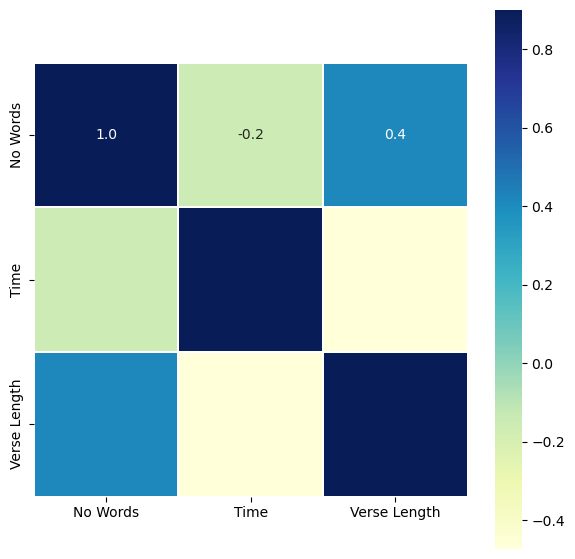

In [18]:
# df_copy = df.copy()

# verse_words['Verse Length'] = round(verse_words['No Words']/verse_words['Book Number'],0)
# verse_words = verse_words.sort_values(by='Verse Length',ascending=False)
# verse_words['Book Name'] = df_copy['Book Name']
# df_to_merge = df_copy.set_index('Book Name')
# verse_words['Book Name'] = df_to_merge.index
# verse_words = verse_words.merge(df_to_merge, left_on='Book Name', right_on='Book Name')

# SpearmanCorr = verse_words[['No Words','Time','Verse Length']].corr(method="spearman")
# plt.figure(figsize=(7,7))
# sns.heatmap(SpearmanCorr, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

df_copy = df.copy()

verse_wordss = pd.DataFrame()

verse_wordss["Verse Length"] = round(
    verse_words["No Words"] / verse_words["Book Number"], 0
)
verse_wordss = verse_wordss.sort_values(by="Verse Length", ascending=False)

# Reset the index of verse_words
verse_wordss.reset_index(inplace=True)

# Merge on 'Book Name' column
verse_wordss = verse_wordss.merge(df_copy, on="Book Name")

SpearmanCorr = verse_wordss[["No Words", "Time", "Verse Length"]].corr(
    method="spearman"
)
plt.figure(figsize=(7, 7))
sns.heatmap(
    SpearmanCorr,
    vmax=0.9,
    square=True,
    annot=True,
    linewidths=0.3,
    cmap="YlGnBu",
    fmt=".1f",
)

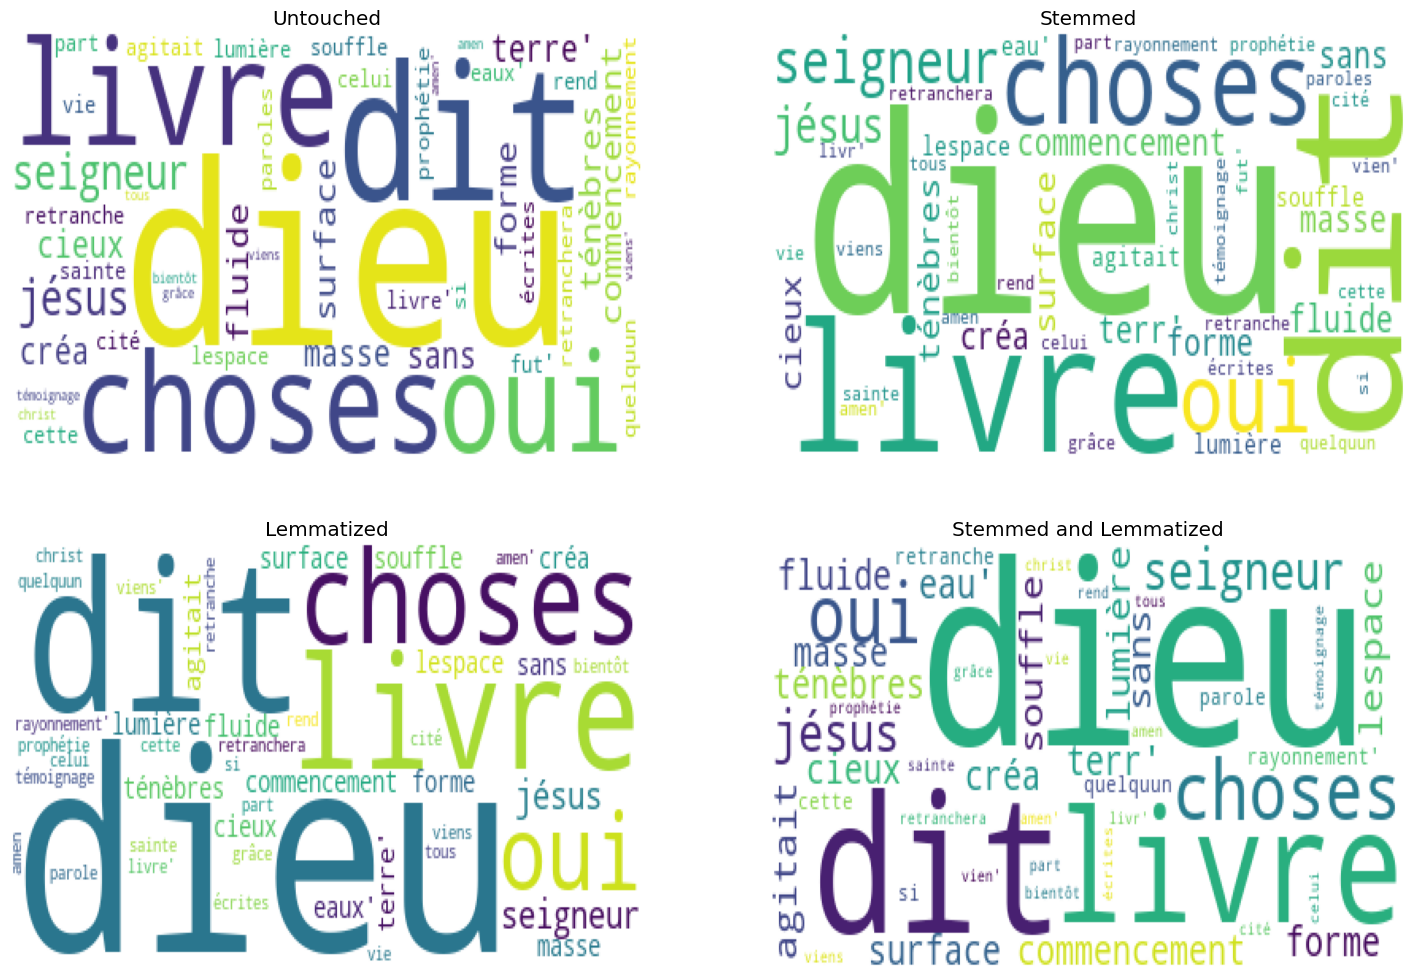

In [19]:
mpl.rcParams["figure.figsize"] = (10, 10)
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.subplot.bottom"] = 0.1

wordcloud_t = WordCloud(background_color="white", stopwords=sw).generate(
    str(df["Text"].values)
)
wordcloud_t_stem = WordCloud(background_color="white", stopwords=sw).generate(
    str(df["Text_Stem"].values)
)
wordcloud_t_lem = WordCloud(background_color="white", stopwords=sw).generate(
    str(df["Text_Lem"].values)
)
wordcloud_t_stem_lem = WordCloud(background_color="white", stopwords=sw).generate(
    str(df["Text_Stem_Lem"].values)
)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
ax0, ax1, ax2, ax3 = ax.flatten()

ax0.imshow(wordcloud_t, aspect="auto")
ax0.title.set_text("Untouched")
ax0.axis("off")

ax1.imshow(wordcloud_t_stem, aspect="auto")
ax1.title.set_text("Stemmed")
ax1.axis("off")

ax2.imshow(wordcloud_t_lem, aspect="auto")
ax2.title.set_text("Lemmatized")
ax2.axis("off")

ax3.imshow(wordcloud_t_stem_lem, aspect="auto")
ax3.title.set_text("Stemmed and Lemmatized")
ax3.axis("off")

plt.show()

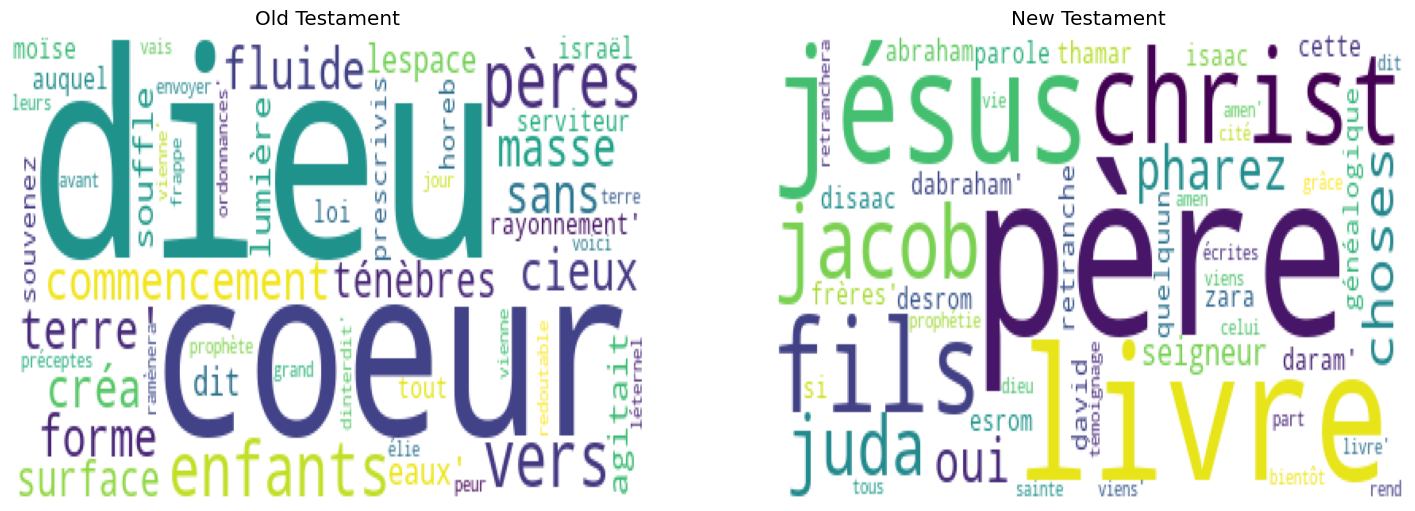

In [20]:
mpl.rcParams["figure.figsize"] = (10, 10)
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.subplot.bottom"] = 0.1

OldTestament = df[df.index < 23145]
NewTestament = df[df.index >= 23145]

wordcloud_OldTestament = WordCloud(background_color="white", stopwords=sw).generate(
    str(OldTestament.Text_Lem.values)
)
wordcloud_NewTestament = WordCloud(background_color="white", stopwords=sw).generate(
    str(NewTestament.Text_Lem.values)
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax0, ax1 = ax.flatten()

ax0.imshow(wordcloud_OldTestament, aspect="auto")
ax0.title.set_text("Old Testament")
ax0.axis("off")

ax1.imshow(wordcloud_NewTestament, aspect="auto")
ax1.title.set_text("New Testament")
ax1.axis("off")

plt.show()

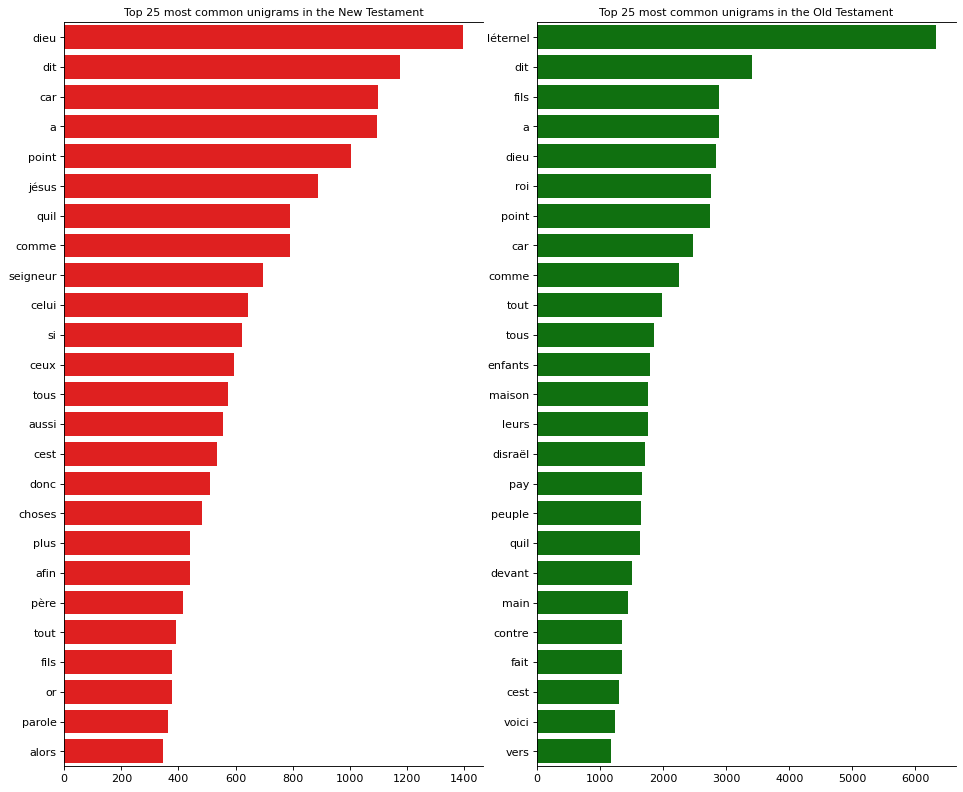

In [21]:
# Unigrams
NT_unigrams = defaultdict(int)  # New Testament
OT_unigrams = defaultdict(int)  # Old Testament

for line in NewTestament["Text_Lem"]:
    for word in generate_ngrams(line):
        NT_unigrams[word] += 1

for line in OldTestament["Text_Lem"]:
    for word in generate_ngrams(line):
        OT_unigrams[word] += 1

df_NT_unigrams = pd.DataFrame(sorted(NT_unigrams.items(), key=lambda x: x[1])[::-1])
df_OT_unigrams = pd.DataFrame(sorted(OT_unigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(
    y=df_NT_unigrams[0].values[:N],
    x=df_NT_unigrams[1].values[:N],
    ax=axes[0],
    color="red",
)
sns.barplot(
    y=df_OT_unigrams[0].values[:N],
    x=df_OT_unigrams[1].values[:N],
    ax=axes[1],
    color="green",
)

for i in range(2):
    axes[i].spines["right"].set_visible(False)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis="x", labelsize=10)
    axes[i].tick_params(axis="y", labelsize=10)

axes[0].set_title(f"Top {N} most common unigrams in the New Testament", fontsize=10)
axes[1].set_title(f"Top {N} most common unigrams in the Old Testament", fontsize=10)

plt.show()

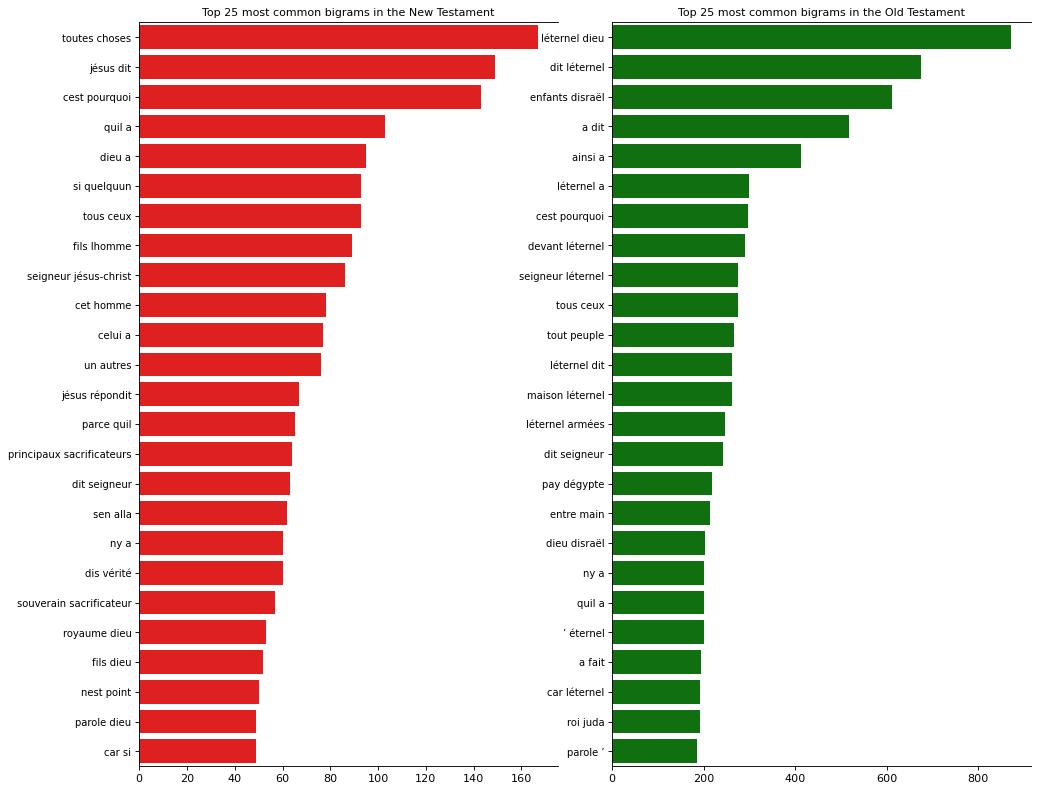

In [22]:
# Bigrams
NT_bigrams = defaultdict(int)
OT_bigrams = defaultdict(int)

for line in NewTestament["Text_Lem"]:
    for word in generate_ngrams(line, n_gram=2):
        NT_bigrams[word] += 1

for line in OldTestament["Text_Lem"]:
    for word in generate_ngrams(line, n_gram=2):
        OT_bigrams[word] += 1

df_NT_bigrams = pd.DataFrame(sorted(NT_bigrams.items(), key=lambda x: x[1])[::-1])
df_OT_bigrams = pd.DataFrame(sorted(OT_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(
    y=df_NT_bigrams[0].values[:N],
    x=df_NT_bigrams[1].values[:N],
    ax=axes[0],
    color="red",
)
sns.barplot(
    y=df_OT_bigrams[0].values[:N],
    x=df_OT_bigrams[1].values[:N],
    ax=axes[1],
    color="green",
)

for i in range(2):
    axes[i].spines["right"].set_visible(False)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis="x", labelsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[0].set_title(f"Top {N} most common bigrams in the New Testament", fontsize=10)
axes[1].set_title(f"Top {N} most common bigrams in the Old Testament", fontsize=10)

plt.show()

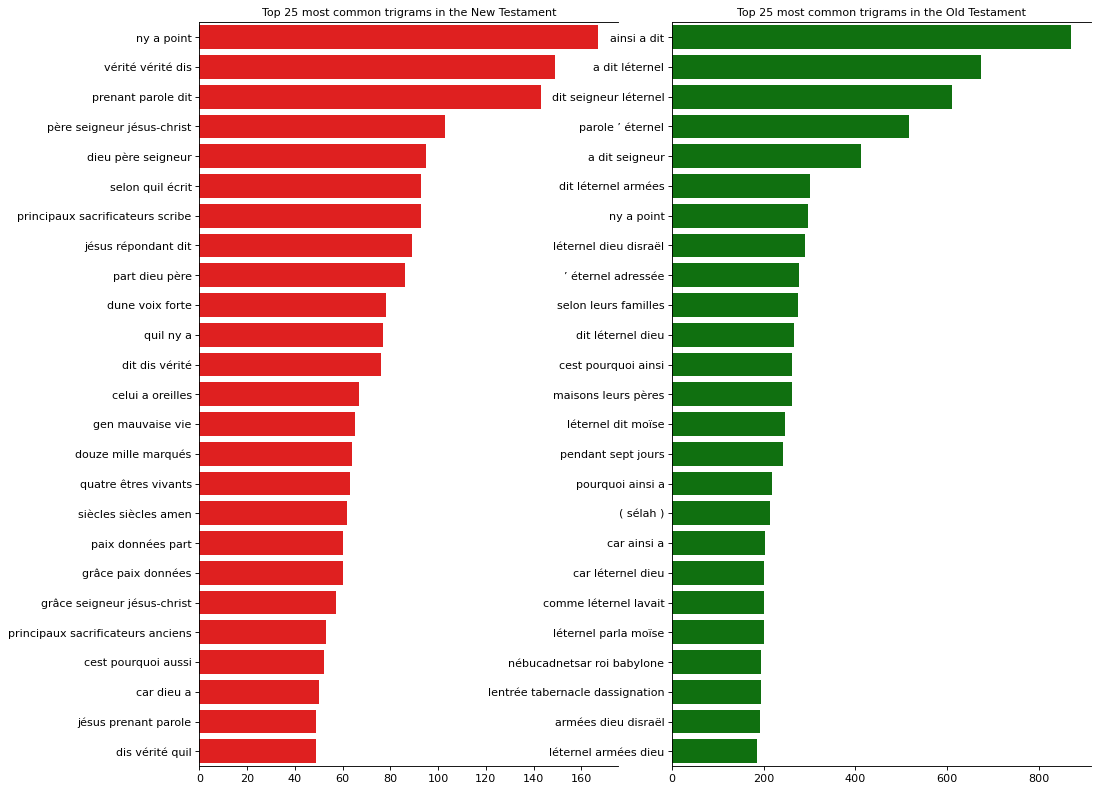

In [23]:
# Trigrams
NT_trigrams = defaultdict(int)
OT_trigrams = defaultdict(int)

for line in NewTestament["Text_Lem"]:
    for word in generate_ngrams(line, n_gram=3):
        NT_trigrams[word] += 1

for line in OldTestament["Text_Lem"]:
    for word in generate_ngrams(line, n_gram=3):
        OT_trigrams[word] += 1

df_NT_trigrams = pd.DataFrame(sorted(NT_trigrams.items(), key=lambda x: x[1])[::-1])
df_OT_trigrams = pd.DataFrame(sorted(OT_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(
    y=df_NT_trigrams[0].values[:N],
    x=df_NT_bigrams[1].values[:N],
    ax=axes[0],
    color="red",
)
sns.barplot(
    y=df_OT_trigrams[0].values[:N],
    x=df_OT_bigrams[1].values[:N],
    ax=axes[1],
    color="green",
)

for i in range(2):
    axes[i].spines["right"].set_visible(False)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis="x", labelsize=10)
    axes[i].tick_params(axis="y", labelsize=10)

axes[0].set_title(f"Top {N} most common trigrams in the New Testament", fontsize=10)
axes[1].set_title(f"Top {N} most common trigrams in the Old Testament", fontsize=10)

plt.show()

In [24]:
# Define the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000)

# Fit and transform the text data
X = vectorizer.fit_transform(df.Text_Lem)

# Perform Truncated SVD for dimensionality reduction
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X = svd.fit_transform(X)

# Create a DataFrame to hold the clustered data
cluster_data = pd.DataFrame(
    {
        "Comp1": X[:, 0],
        "Comp2": X[:, 1],
        "Testament": df.Testament,
        "Book Name": df["Book Name"],
        "Period": df.Period,
        "Location": df.Location,
        "Time": df.Time,
    }
)

# Display the first few rows of the clustered data
cluster_data.head()

,Comp1,Comp2,Testament,Book Name,Period,Location,Time
0,0.134486,-0.059980,Ancien,Genèse,Persian,Israel,-500
1,0.108752,-0.045905,Ancien,Genèse,Persian,Israel,-500
2,0.212958,-0.073655,Ancien,Genèse,Persian,Israel,-500
3,0.114781,-0.048666,Ancien,Genèse,Persian,Israel,-500
4,0.100535,-0.028859,Ancien,Genèse,Persian,Israel,-500


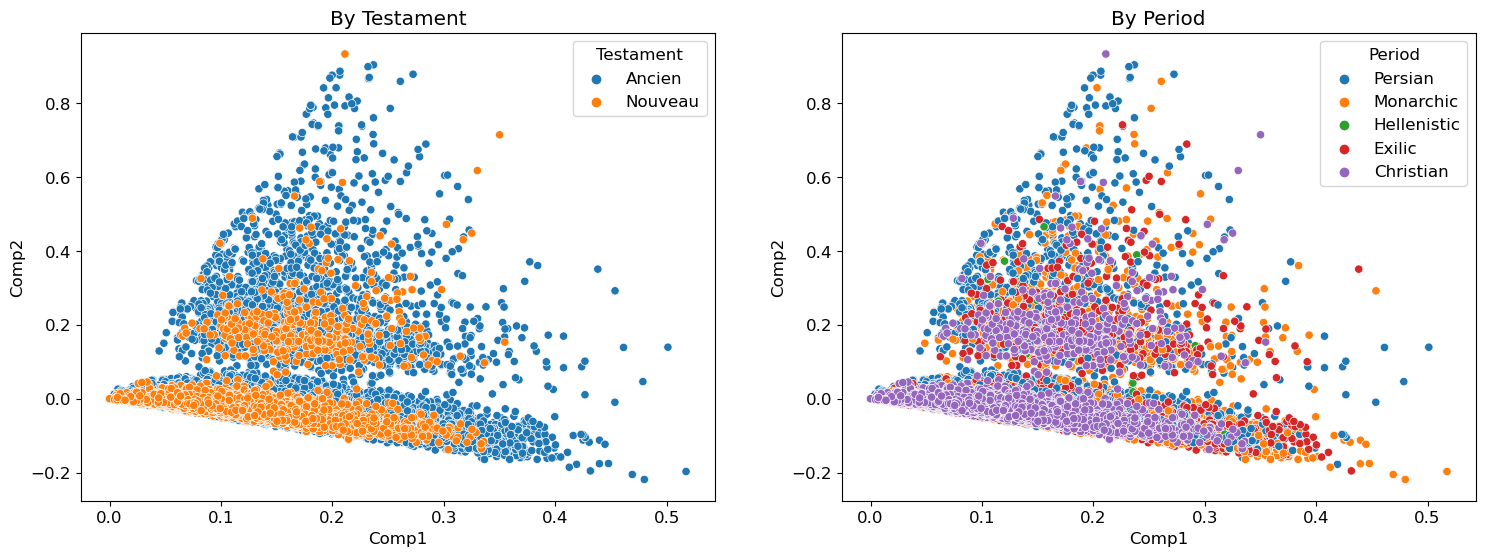

In [25]:
# Create subplots to display clusters by 'Testament' and 'Period'
f, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot clusters by 'Testament'
sns.scatterplot(
    x="Comp1", y="Comp2", hue="Testament", data=cluster_data, ax=axes[0]
).set_title("By Testament")

# Plot clusters by historical 'Period'
sns.scatterplot(
    x="Comp1", y="Comp2", hue="Period", data=cluster_data, ax=axes[1]
).set_title("By Period")

plt.show()

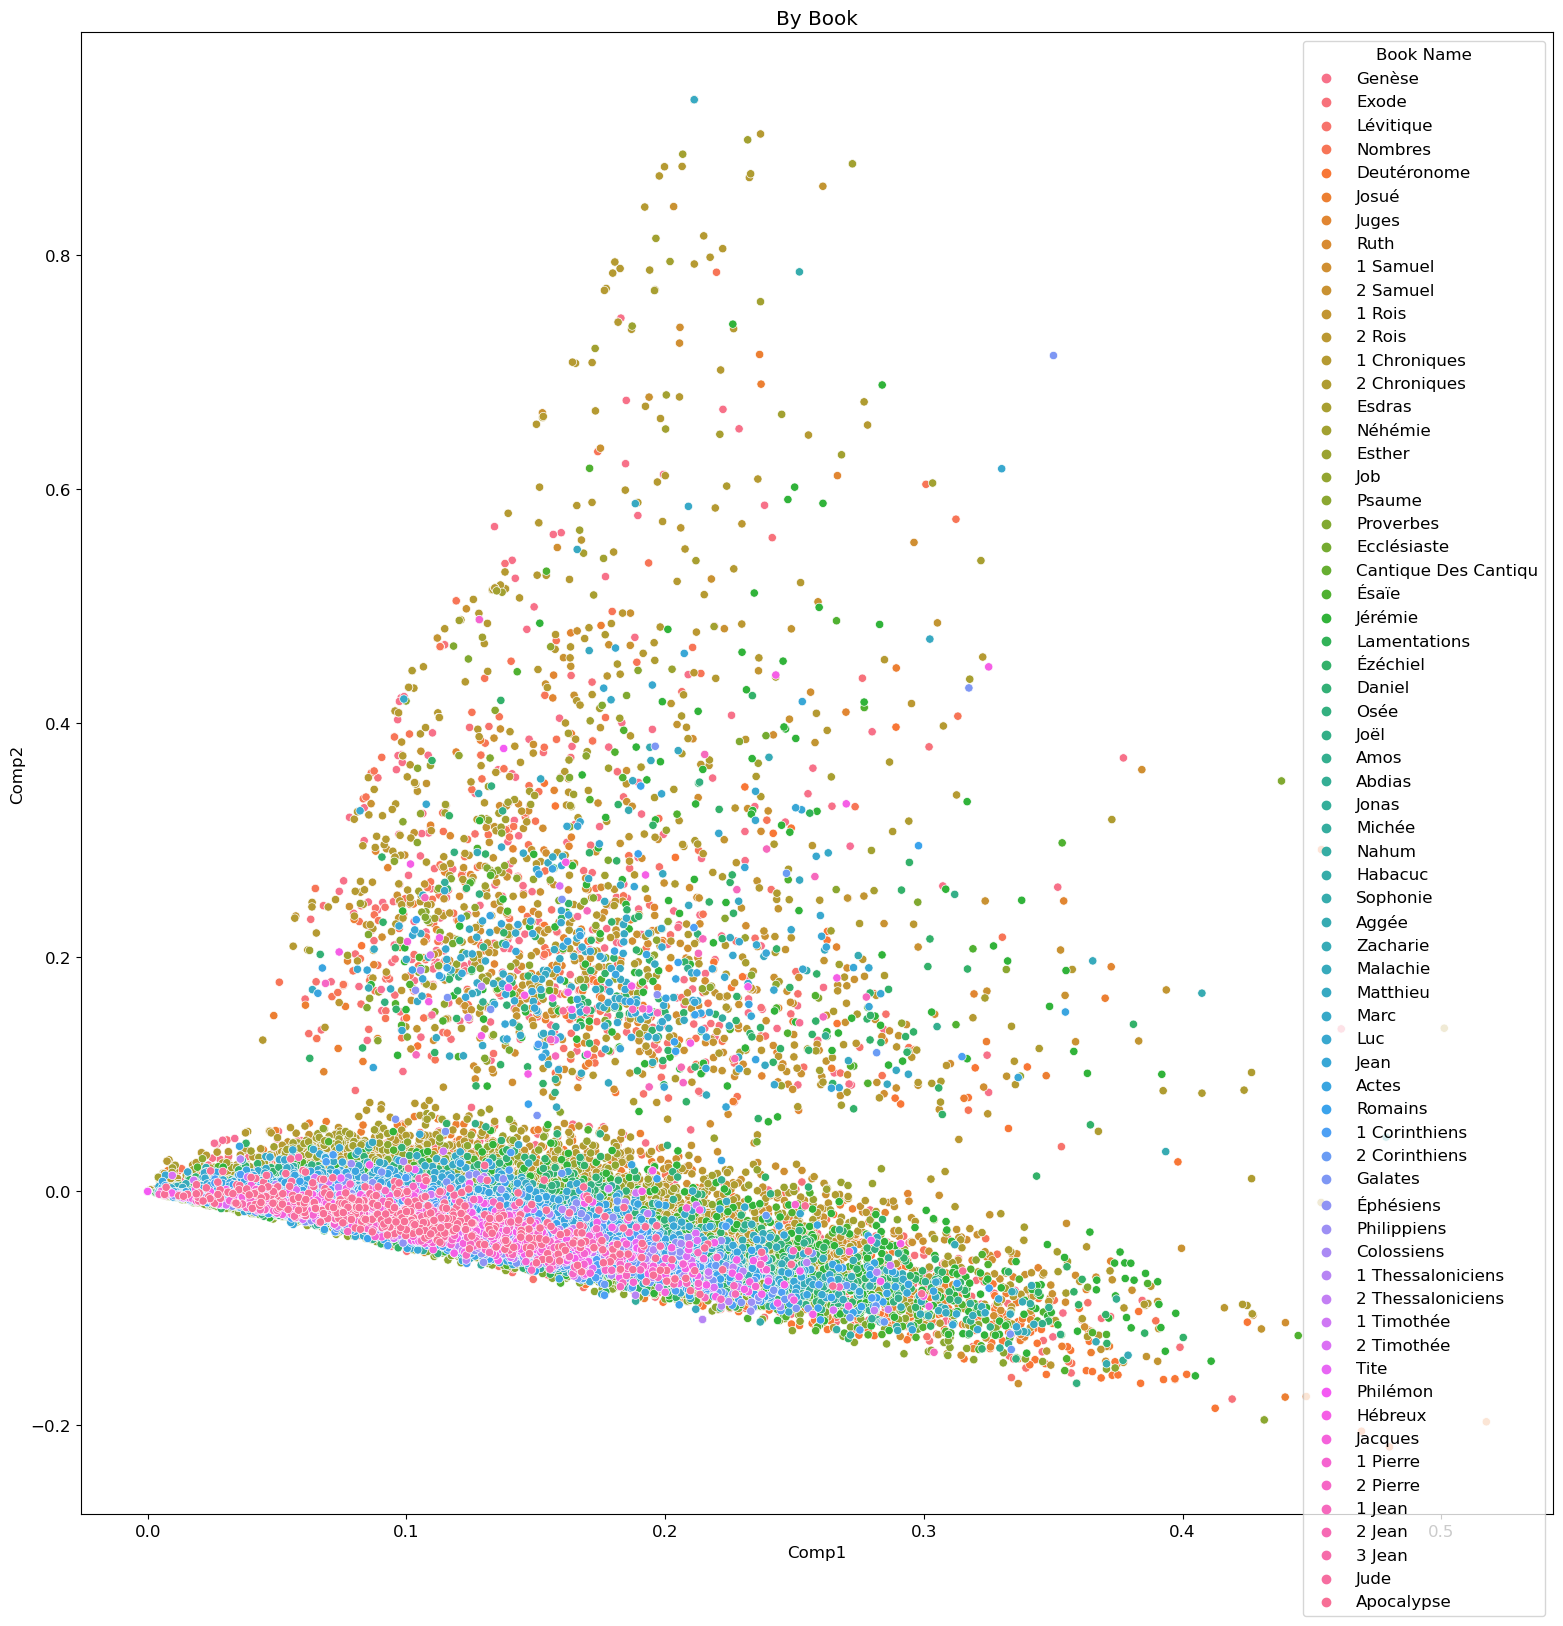

In [26]:
# Set the figure size
plt.figure(figsize=(19, 19))

# Create the scatter plot
sns.scatterplot(x="Comp1", y="Comp2", data=cluster_data, hue="Book Name").set_title(
    "By Book"
)

plt.show()

In [27]:
Target = df["Testament"]

df["Testament Relabeled"] = df["Testament"]
df["Testament Relabeled"] = df["Testament Relabeled"].replace("Nouveau", 1)
df["Testament Relabeled"] = df["Testament Relabeled"].replace("Ancien", 0)

df_train, df_test, y_train, y_test = train_test_split(
    df, Target, test_size=0.2, random_state=0
)

In [28]:
def build_vocab(X):
    tweets = X.apply(lambda s: s.split()).values
    vocab = {}
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):
    vocab = build_vocab(X)
    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]

    vocab_coverage = len(covered) / len(vocab)
    text_coverage = n_covered / (n_covered + n_oov)
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

In [29]:
# !kaggle datasets download -d authman/pickled-crawl300d2m-for-kernel-competitions
# !kaggle datasets download -d authman/pickled-glove840b300d-for-10sec-loading